# Digital House - Data Science a Distancia

## Trabajo Práctico 2



### Autores: Nahuel Bonfante, Daniel Borrino, Ivan Mongi, Jessica Polakoff, Julio Tentor

<p style="text-align:right;">Abril 2022</p>

#### Aspectos técnicos
La notebook se ejecuta correctamente en una instalación estándar de Anaconda versión 4.11.0 build  3.21.6, Python 3.9.7


#### Librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
import statsmodels.api as sm

In [5]:
# Ignore some warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

---
### Dataset

In [6]:
data_final_url = "../Data/properatti_final2.csv"
data_final = pd.read_csv(data_final_url, encoding="utf-8")

In [7]:
mask = data_final['state_name'] == 'Córdoba'

mask = np.logical_and(mask, data_final['place_name'] == 'Córdoba')

data = data_final[mask].copy()

---

In [8]:
data.reset_index(inplace=True)

In [9]:
dummies = pd.get_dummies(data=data['property_type'])

In [10]:
data = pd.concat([data, dummies], axis=1)

In [11]:
# Trabajar con precio en miles de dólares
data['price_aprox_usd'] = data['price_aprox_usd'] / 1000

In [12]:
data.shape

(3662, 17)

In [13]:
data.head()

,index,Unnamed: 0,property_type,place_name,state_name,price_aprox_usd,surface_covered_in_m2,cochera,pileta,parrilla,amoblado,patio,terraza,jardin,ambientes_final,apartment,house
0,48,89,apartment,Córdoba,Córdoba,50.00000,53.0,0,0,0,0,0,0,0,1.0,1,0
1,49,92,apartment,Córdoba,Córdoba,120.00000,73.0,0,0,0,0,0,0,0,2.0,1,0
2,50,93,house,Córdoba,Córdoba,385.00000,416.0,0,0,0,0,0,0,0,3.0,0,1
3,53,99,house,Córdoba,Córdoba,47.67112,180.0,1,0,0,0,1,1,0,NaN,0,1
4,104,191,apartment,Córdoba,Córdoba,145.00000,85.0,0,0,0,0,0,0,0,2.0,1,0


---


In [14]:

sns.set()
plt.style.use('classic')


In [15]:
features = ['price_aprox_usd', 'surface_covered_in_m2', 'apartment', 'house', 'cochera', 'pileta', 'patio', 'terraza']

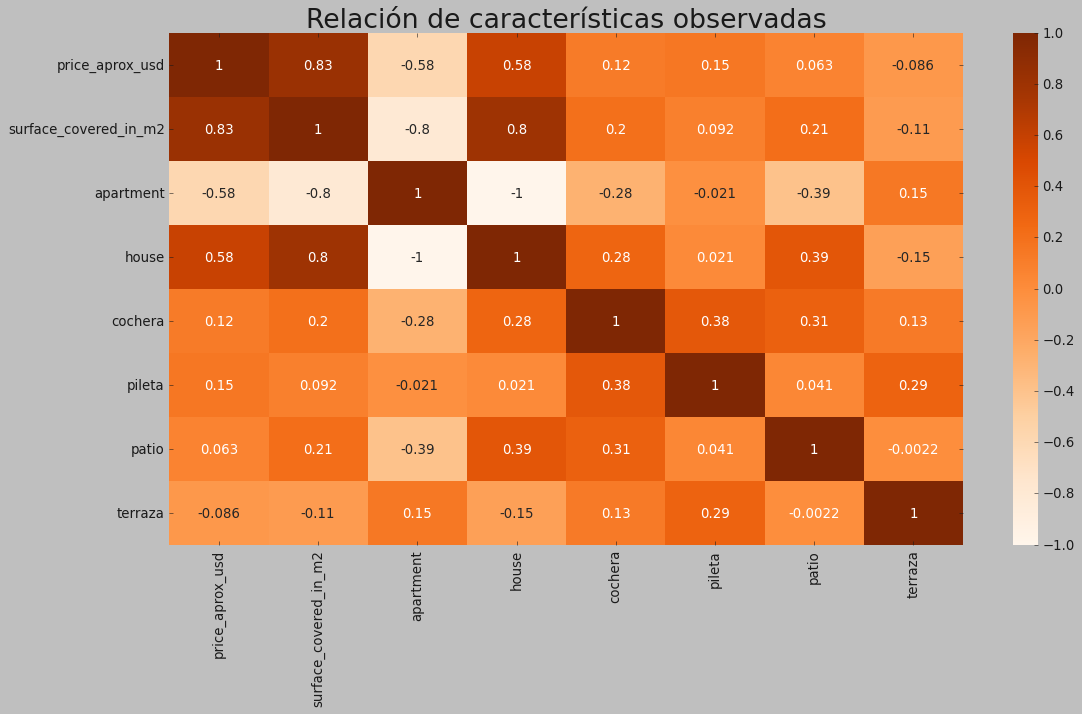

In [16]:
plt.figure(figsize=(16, 8))
sns.heatmap(data[features].corr(), annot=True, vmin=-1, vmax=1, cmap='Oranges')
plt.title("Relación de características observadas", fontdict={'fontsize': 24})
plt.show()

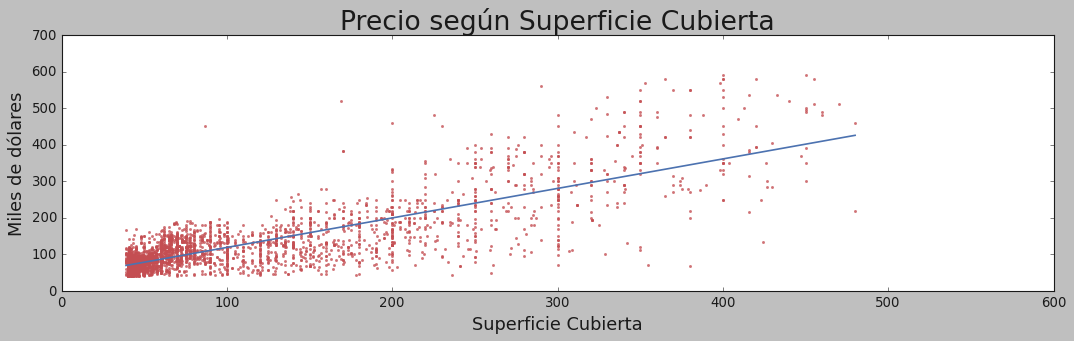

In [17]:
plt.figure(figsize=(16, 4))
sns.regplot(data = data, x = 'surface_covered_in_m2', y = 'price_aprox_usd', ci = None, scatter_kws = {'color':'r', 's':4})
plt.title("Precio según Superficie Cubierta", fontdict = {'fontsize': 24})
plt.ylabel('Miles de dólares', fontdict = {'fontsize': 16})
plt.xlabel("Superficie Cubierta", fontdict = {'fontsize': 16})
plt.show()

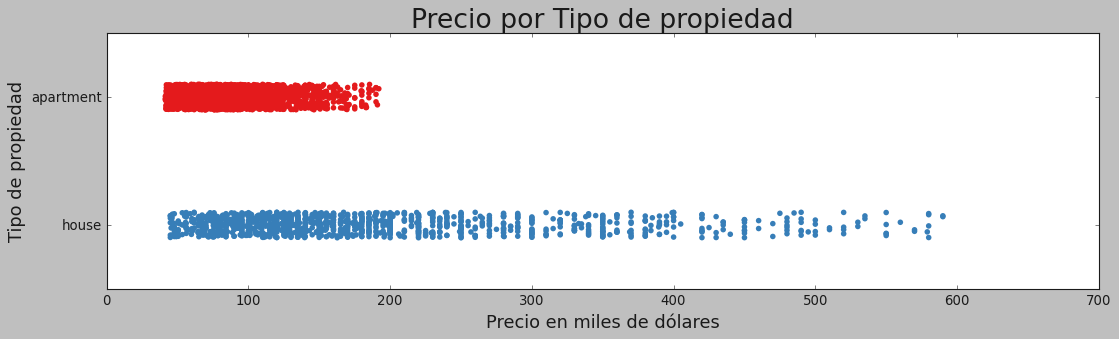

In [18]:
plt.figure(figsize=(16, 4))
sns.stripplot(y = 'property_type', x = "price_aprox_usd", data = data, orient= 'h', palette = 'Set1', size = 5)
plt.title("Precio por Tipo de propiedad", fontdict = {'fontsize': 24})
plt.ylabel('Tipo de propiedad', fontdict = {'fontsize': 16})
plt.xlabel("Precio en miles de dólares", fontdict = {'fontsize': 16})
plt.show()

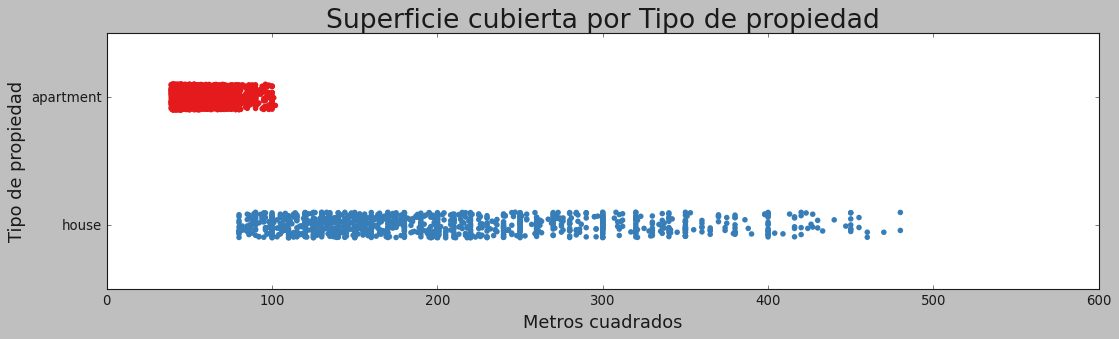

In [19]:
plt.figure(figsize=(16, 4))
sns.stripplot(y = 'property_type', x = "surface_covered_in_m2", data = data, orient= 'h', palette = 'Set1', size = 5)
plt.title("Superficie cubierta por Tipo de propiedad", fontdict = {'fontsize': 24})
plt.ylabel('Tipo de propiedad', fontdict = {'fontsize': 16})
plt.xlabel("Metros cuadrados", fontdict = {'fontsize': 16})
plt.show()

---



In [20]:
def train_LinearRegression(X, y) :
    u""" Performs Ordinary Least Squares linear regression
    
    one from Scikit-Learn linear models and two from statsmodels

    Args:
    * X array of array of features
    * y array of target values

    
    
    """
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
    
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    
    __mae = mean_absolute_error(ytest, ypred).round(3)
    __mse = mean_squared_error(ytest, ypred).round(3)
    __rmse = np.sqrt(__mse).round(3)

    result_train = sm.OLS(ytrain, sm.add_constant(Xtrain)).fit()    
    r2a_train = result_train.rsquared_adj

    result_test = sm.OLS(ytest, sm.add_constant(Xtest)).fit()    
    r2a_test = result_test.rsquared_adj
    
    
    df = pd.DataFrame()

    df = pd.concat([df, pd.DataFrame(columns=['Features'], data=[ str(list(X.columns)) ] )], axis=1)

    df = pd.concat([df, pd.DataFrame(columns=['MAE'], data=[__mae] )], axis=1)
    df = pd.concat([df, pd.DataFrame(columns=['MSE'], data=[__mse] )], axis=1)
    df = pd.concat([df, pd.DataFrame(columns=['sqrt MSE'], data=[__rmse] )], axis=1)

    df = pd.concat([df, pd.DataFrame(columns=['R2 adj train'], data=[r2a_train] )], axis=1)
    df = pd.concat([df, pd.DataFrame(columns=['R2 adj test'], data=[r2a_test] )], axis=1)
    
    return model, df

    


In [21]:
def stats_OLS(X, y) :
    u""" Performs an Ordinary Least Squares linear regression from statsmodels
    X array of array of features
    y array of target values
    Returns a RegressionResult object
    """

    __X = sm.add_constant(X)
    result = sm.OLS(y, __X).fit()
    
    return result

---
### Train models


In [22]:
pd.options.display.max_colwidth = 80

In [23]:

y = data['price_aprox_usd']
metrics = pd.DataFrame()


In [24]:

X = data[['surface_covered_in_m2']]
model, metric = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [25]:

X = data[['surface_covered_in_m2', 'house']]
model, metric = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [26]:

X = data[['surface_covered_in_m2','cochera']]
model, metric = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [27]:

X = data[['surface_covered_in_m2','pileta']]
model, metric = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [28]:

X = data[['surface_covered_in_m2','patio']]
model, metric = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [29]:

X = data[['surface_covered_in_m2','terraza']]
model, metric = train_LinearRegression(X, y)
metrics = metrics.append(metric)


---

In [30]:

X = data[['surface_covered_in_m2', 'house', 'cochera']]
model, metric = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [31]:

X = data[['surface_covered_in_m2', 'house', 'pileta']]
model, metric = train_LinearRegression(X, y)
metrics = metrics.append(metric)


---

In [32]:

X = data[['surface_covered_in_m2', 'house', 'cochera', 'pileta']]
model, metric = train_LinearRegression(X, y)
metrics = metrics.append(metric)


---

In [33]:

X = data[['surface_covered_in_m2', 'house', 'cochera', 'pileta', 'patio', 'terraza']]
model, metric = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [34]:
display(metrics.head(20))

,Features,MAE,MSE,sqrt MSE,R2 adj train,R2 adj test
0,['surface_covered_in_m2'],31.341,2253.111,47.467,0.669672,0.712869
0,"['surface_covered_in_m2', 'house']",30.329,2073.590,45.537,0.688544,0.736001
0,"['surface_covered_in_m2', 'cochera']",31.523,2243.508,47.366,0.671365,0.713916
0,"['surface_covered_in_m2', 'pileta']",31.080,2204.946,46.957,0.675303,0.718389
0,"['surface_covered_in_m2', 'patio']",31.318,2175.756,46.645,0.684202,0.723520
0,"['surface_covered_in_m2', 'terraza']",31.349,2253.511,47.471,0.669555,0.712828
0,"['surface_covered_in_m2', 'house', 'cochera']",30.460,2076.725,45.571,0.688749,0.735726
0,"['surface_covered_in_m2', 'house', 'pileta']",30.079,2040.729,45.174,0.692500,0.739616
0,"['surface_covered_in_m2', 'house', 'cochera', 'pileta']",30.414,2045.281,45.225,0.694833,0.739631
0,"['surface_covered_in_m2', 'house', 'cochera', 'pileta', 'patio', 'terraza']",30.478,2032.034,45.078,0.700432,0.741631


In [35]:
# casa de 150 m2 cubiertos con cochera y pileta
my_X = [[150, 1, 1, 1, 0, 0]]
model.predict(my_X)[0]

161.5632976058686

---
### Gauss-Markov


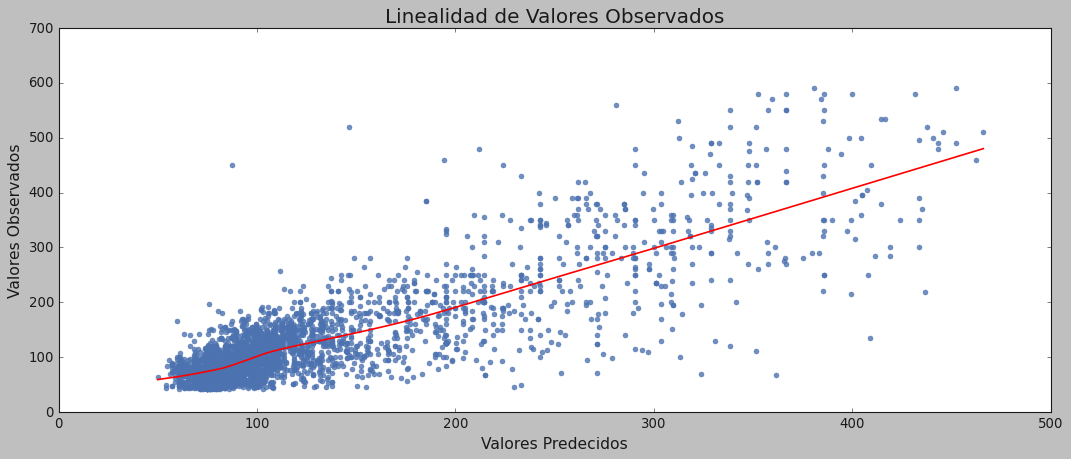

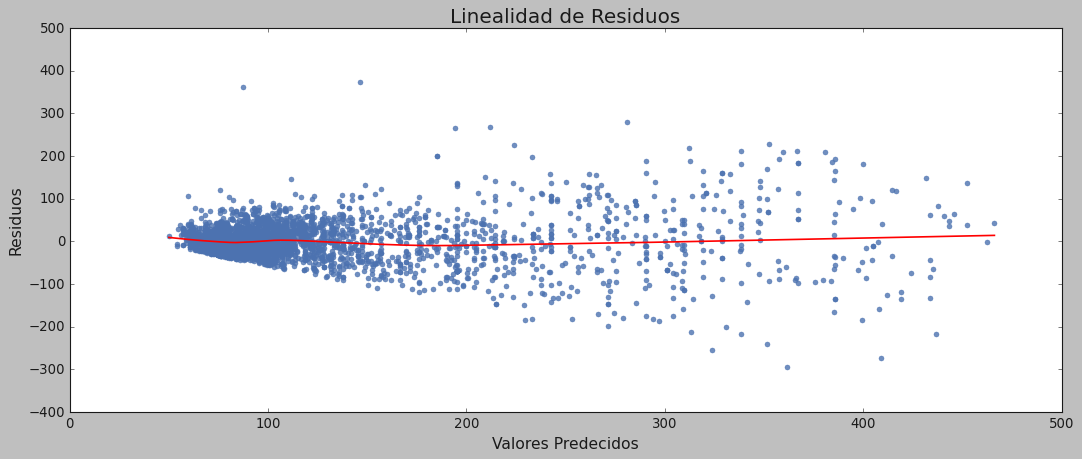

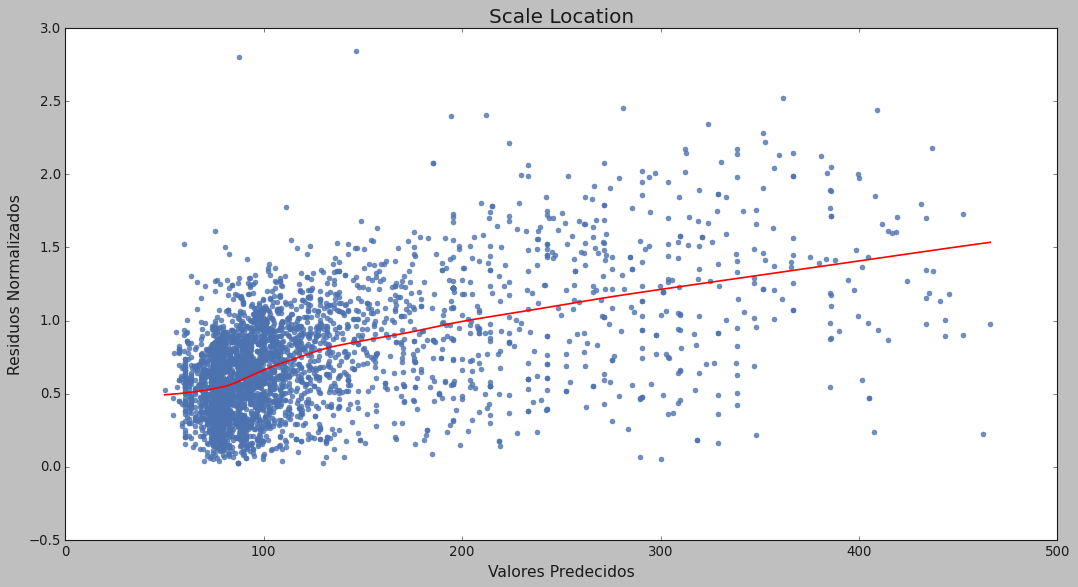

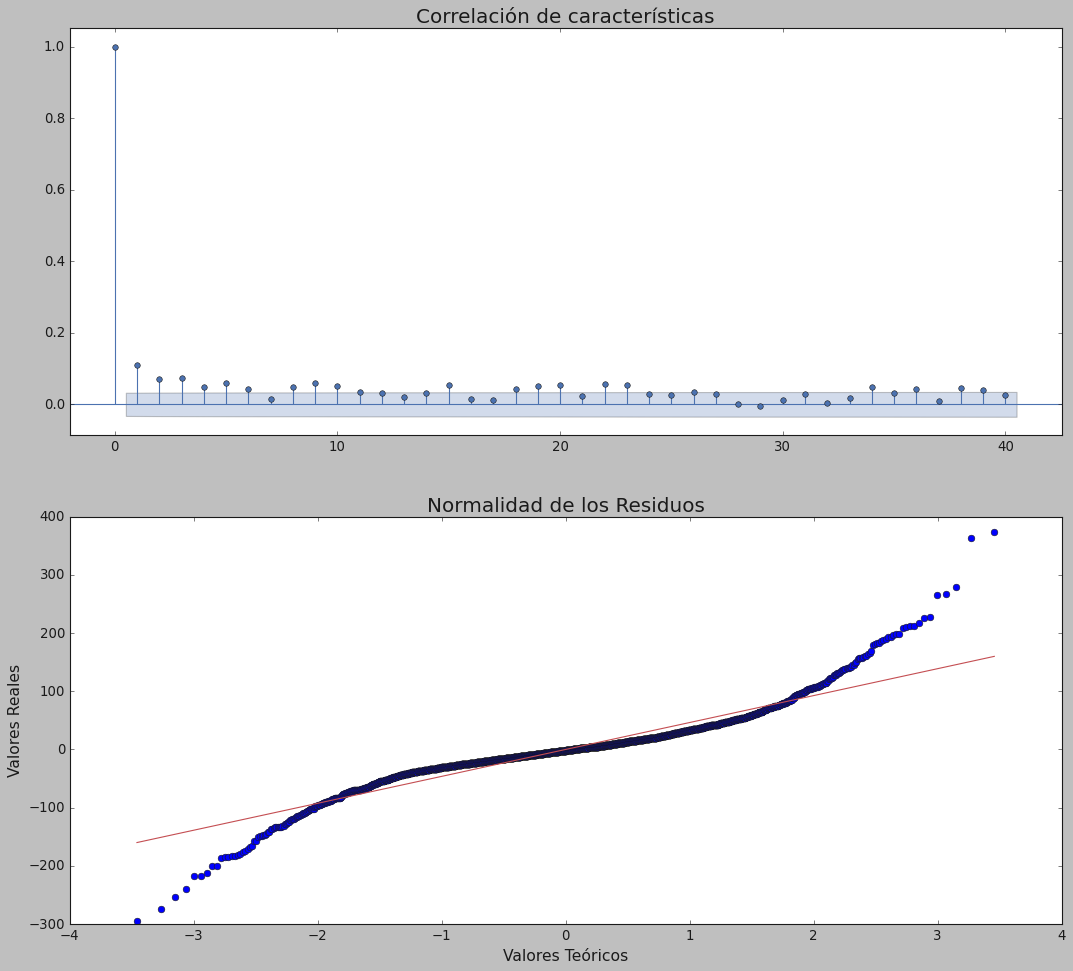

In [36]:
def gauss_markov_test(model, ytest):
    u"""
    funcion para visualizar e identificar supuestos de linealidad sobre la regression lineal
    
    Args:
    * model - fitted OLS model from statsmodels
    * ytest - observed values
    """
    
    ypred = model.predict()
    resid = model.resid
    rstud = model.get_influence().resid_studentized_internal
    rsqrt = np.sqrt(np.abs(rstud))

    
    plt.figure(figsize=(16, 6))
    sns.regplot(x = ypred, y = ytest, lowess = True, line_kws = {'color': 'red'})
    plt.title('Linealidad de Valores Observados', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Valores Observados', fontdict = {'fontsize': 14})
    plt.show()

    plt.figure(figsize=(16, 6))
    sns.regplot(x = ypred, y = resid, lowess = True, line_kws = {'color': 'red'})
    plt.title('Linealidad de Residuos', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Residuos', fontdict = {'fontsize': 14})
    plt.show()
    
    plt.figure(figsize=(16, 8))
    sns.regplot(x = ypred, y = rsqrt, lowess = True, line_kws = {'color': 'red'})
    plt.title('Scale Location', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Residuos Normalizados', fontdict = {'fontsize': 14})
    plt.show()

    
    sns.mpl.rcParams['figure.figsize'] = (16, 8)
    fig, ax = plt.subplots(2)

    sm.graphics.tsa.plot_acf(x = resid, ax = ax[0], lags = 40 , alpha = 0.05, title = '')
    ax[0].set_title('Correlación de características', fontdict = {'fontsize': 18})

    plt.subplots_adjust(top = 1.5, wspace = 2)

    sm.ProbPlot(model.resid).qqplot(ax = ax[1], line = 's')
    ax[1].set_title('Normalidad de los Residuos', fontdict = {'fontsize': 18})
    ax[1].set_xlabel("Valores Teóricos", fontsize = 14)
    ax[1].set_ylabel("Valores Reales", fontsize = 14)
    plt.show()
    
    return


X = data[['surface_covered_in_m2', 'house', 'cochera', 'pileta', 'patio', 'terraza']]
y = data['price_aprox_usd']

ols_model = stats_OLS(X, y)
gauss_markov_test(ols_model, y)
